In [2]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install scipy
!pip install numpy


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## All imports:

In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.stats import kruskal
from scipy.stats import norm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, log_evaluation 
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor, Pool
import scipy.stats as stats
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation

## Using the alterations to the dataset from Clustering & General Model:

In [4]:
# Load the dataset
file_path = "ICU_SPINAL_PATIENT_FEATURES_VITALS_EXT.csv"
df = pd.read_csv(file_path)

# Preview the data
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   subject_id           5290 non-null   int64  
 1   hadm_id              5290 non-null   int64  
 2   stay_id              5290 non-null   int64  
 3   intime               5290 non-null   object 
 4   outtime              5290 non-null   object 
 5   los                  5290 non-null   float64
 6   icd_code             5290 non-null   object 
 7   long_title           5290 non-null   object 
 8   gender               5290 non-null   object 
 9   anchor_age           5290 non-null   int64  
 10  dod                  2048 non-null   object 
 11  admission_type       5290 non-null   object 
 12  admission_location   5290 non-null   object 
 13  insurance            5290 non-null   object 
 14  marital_status       4838 non-null   object 
 15  race                 5290 non-null   o

In [5]:
# Define WBC-related columns to drop
wbc_columns = ['avg_wbc', 'min_wbc', 'max_wbc']
# Drop the columns from the DataFrame
df = df.drop(columns=wbc_columns)

# Define inverse transform sampling function
def inverse_transform_impute(column):
    observed = column.dropna().values
    n_missing = column.isna().sum()
    # Sample from observed distribution
    imputed = np.random.choice(observed, size=n_missing, replace=True)
    # Fill missing entries
    col_filled = column.copy()
    col_filled[column.isna()] = imputed
    return col_filled

#Only check numeric columns for missingness
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_cols_with_nan = [col for col in numeric_cols if df[col].isna().any()]
# Apply inverse transform imputation
for col in num_cols_with_nan:
    df[col] = inverse_transform_impute(df[col])

In [6]:
# Create binary mortality flag: 1 if DOD is not null, else 0
df['mortality_flag'] = df['dod'].notna().astype(int)
# Dropping DOD as it is no longer useful
df = df.drop(columns=['dod'])

In [7]:
# Get the frequency of each injury type
long_title_counts = df['long_title'].value_counts()

# Identify titles that occur less than 10 times
rare_titles = long_title_counts[long_title_counts < 10].index
not_rare_titles = long_title_counts[long_title_counts >= 10].index

# Step 3: Count number of patients in each group
num_people_less_than_10 = df[df['long_title'].isin(rare_titles)].shape[0]
num_people_greater_equal_10 = df[df['long_title'].isin(not_rare_titles)].shape[0]

print(len(rare_titles))
print(len(not_rare_titles))
print(num_people_less_than_10)
print(num_people_greater_equal_10)

180
69
541
4749


In [8]:
# Step 3: Replace those in the DataFrame with "Rare Injury"
df['long_title_grouped'] = df['long_title'].apply(lambda x: 'Rare Injury' if x in rare_titles else x)
print(df['long_title_grouped'].head())

0    Tuberculosis of vertebral column, tubercle bac...
1         Degeneration of cervical intervertebral disc
2    Degeneration of lumbar or lumbosacral interver...
3                             Cerebrospinal fluid leak
4                                          Rare Injury
Name: long_title_grouped, dtype: object


In [9]:
# Mapping dictionary for race aggregation
race_mapping = {
    'WHITE': 'White',
    'WHITE - OTHER EUROPEAN': 'White',
    'WHITE - RUSSIAN': 'White',
    'WHITE - BRAZILIAN': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',

    'BLACK/AFRICAN AMERICAN': 'Black',
    'BLACK/CAPE VERDEAN': 'Black',
    'BLACK/CARIBBEAN ISLAND': 'Black',
    'BLACK/AFRICAN': 'Black',

    'HISPANIC OR LATINO': 'Hispanic',
    'HISPANIC/LATINO - PUERTO RICAN': 'Hispanic',
    'HISPANIC/LATINO - DOMINICAN': 'Hispanic',
    'HISPANIC/LATINO - GUATEMALAN': 'Hispanic',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'Hispanic',
    'HISPANIC/LATINO - SALVADORAN': 'Hispanic',
    'HISPANIC/LATINO - HONDURAN': 'Hispanic',
    'HISPANIC/LATINO - CUBAN': 'Hispanic',
    'HISPANIC/LATINO - COLUMBIAN': 'Hispanic',
    'HISPANIC/LATINO - MEXICAN': 'Hispanic',

    'ASIAN': 'Asian',
    'ASIAN - CHINESE': 'Asian',
    'ASIAN - ASIAN INDIAN': 'Asian',
    'ASIAN - SOUTH EAST ASIAN': 'Asian',
    'ASIAN - KOREAN': 'Asian',

    'AMERICAN INDIAN/ALASKA NATIVE': 'Native American or Pacific Islander',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Native American or Pacific Islander',

    'OTHER': 'Other',
    'PORTUGUESE': 'Other',
    'SOUTH AMERICAN': 'Other',
    'MULTIPLE RACE/ETHNICITY': 'Other',

    'UNKNOWN': 'Unknown',
    'UNABLE TO OBTAIN': 'Unknown',
    'PATIENT DECLINED TO ANSWER': 'Unknown',
}

# Apply the mapping to create an aggregated race column
df['race_grouped'] = df['race'].map(race_mapping).fillna('Other')  # Handle unmapped cases as 'Other'

# Display value counts for verification
df['race_grouped'].value_counts()

race_grouped
White                                  3819
Unknown                                 576
Black                                   391
Other                                   200
Hispanic                                175
Asian                                   117
Native American or Pacific Islander      12
Name: count, dtype: int64

In [10]:
# Grouping logic for 'admission_type'
admission_type_mapping = {
    'EW EMER.': 'EMERGENCY',
    'DIRECT EMER.': 'EMERGENCY',
    'EU OBSERVATION': 'OBSERVATION',
    'OBSERVATION ADMIT': 'OBSERVATION',
    'DIRECT OBSERVATION': 'OBSERVATION',
    'AMBULATORY OBSERVATION': 'OBSERVATION',
    'SURGICAL SAME DAY ADMISSION': 'SURGICAL',
    'ELECTIVE': 'ELECTIVE',
    'URGENT': 'URGENT'
}

# Apply the grouping
df['admission_type_grouped'] = df['admission_type'].map(admission_type_mapping).fillna('OTHER')

# Grouping logic for 'admission_location'
admission_location_mapping = {
    'EMERGENCY ROOM': 'EMERGENCY',
    'PACU': 'EMERGENCY',
    'TRANSFER FROM HOSPITAL': 'TRANSFER',
    'TRANSFER FROM SKILLED NURSING FACILITY': 'TRANSFER',
    'CLINIC REFERRAL': 'REFERRAL',
    'PHYSICIAN REFERRAL': 'REFERRAL',
    'WALK-IN/SELF REFERRAL': 'SELF-REFERRAL',
    'AMBULATORY SURGERY TRANSFER': 'OTHER',
    'PROCEDURE SITE': 'OTHER',
    'INFORMATION NOT AVAILABLE': 'UNKNOWN'
}

# Apply the grouping
df['admission_location_grouped'] = df['admission_location'].map(admission_location_mapping).fillna('OTHER')

df.drop(columns=['admission_type','admission_location'])
print(df['admission_location_grouped'].head())
print(df['admission_type_grouped'].head())

0         REFERRAL
1            OTHER
2            OTHER
3    SELF-REFERRAL
4    SELF-REFERRAL
Name: admission_location_grouped, dtype: object
0     SURGICAL
1    EMERGENCY
2    EMERGENCY
3       URGENT
4       URGENT
Name: admission_type_grouped, dtype: object


In [11]:
#Removing Unneccesary features
df=df.drop(columns=['hadm_id', 'stay_id', 'intime', 'outtime', 'icd_code', 'long_title', 'race'])

In [12]:
#importing the clusters csv:
clusters = pd.read_csv( 'clusters.csv')

print(clusters.head)

<bound method NDFrame.head of       new_cluster
0               1
1               0
2               0
3               2
4               2
...           ...
5285            2
5286            2
5287            2
5288            0
5289            0

[5290 rows x 1 columns]>


In [13]:
# Concatenate DataFrames horizontally (side by side)
# Assuming 'clusters' is a DataFrame, we can extract the values as a Series
df['new_cluster'] = clusters.values.flatten()  # Flatten to ensure it's a 1D array

# Reset index of both DataFrames to ensure alignment
df.reset_index(drop=True, inplace=True)
clusters.reset_index(drop=True, inplace=True)

# Now assign the cluster column
df['cluster'] = clusters['new_cluster']


## Building Models for each cluster from our Clustering Process:

To reiterate, our main results from PCA clustering were:

Looking at our new results, the top features contributing to each PC remain the same, however with stronger contributions. So we will need to pay special attention to white, male patients in emergencies, particularly those who are under urgent, same day admissions. These patients also appear to be older, around 50-60 years old(based on anchor age) have a slightly low min_SpO2 (blood oxygen levels) across all clusters (should be 0.95 to 1.00), which could indicate respiratory complications.

Cluster 0: Characterized by patients who are primarily referred through physician referrals or other referrals, with a focus on surgical admissions, predominantly married individuals.

Cluster 1: Consists mainly of patients admitted through emergency rooms, with a focus on emergency admissions.

Cluster 2: Primarily transferred from hospitals, with urgent admission types, and higher diagnosis counts.

However, the issue still remains that each cluster seem to have overall, similar distributions for length of stay. Considering this, we will attempt to perform clustering with PCA via direct pair comparisons to obtain more consistent results.

and from Regular clustering via pair analysis of features:

- Cluster 1: has more dx_count, max_creatinine, min_creatinine
- Cluster 0: has more min_SpO2, min_rr, min_hr
- Both: had similar avg_rr, max_rr, max_hr
- dx_count appear to have the greatest difference in influence for both clusters

To further improve the accurracy in predicting LOS, we will attempt to focus on clusters from PCA as they are more representative of all features compared to our regular pair feature clusters.

We will use CatBoost and LightGBM to be consistent with our previous general machine learning models.

We will also be using the same metrics as previously, such as MAE, RMSE, R^2, MAPE and Median Absolute Error.

## LightGBM Models:

### Preprocessing df:

In [14]:
# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Preprocessing ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Categorical Encoding ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

### Cluster 0(Referral Patients):

In [15]:
# --- Filter for Cluster 0 ---
df_cluster_0 = df[df['cluster'] == 0].copy()
target_0 = 'los'
groups_0 = df_cluster_0['subject_id']
X_0 = df_cluster_0.drop(columns=['subject_id', target_0])
y_0 = df_cluster_0[target_0]

# --- Initialize Metrics and CV ---
rmse_scores_0, mae_scores_0, r2_scores_0, mape_scores_0, medae_scores_0 = [], [], [], [], []
gkf_0 = GroupKFold(n_splits=5)

y_true_all_lgb_0, y_pred_all_lgb_0 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_0, val_idx_0) in enumerate(gkf_0.split(X_0, y_0, groups_0)):
    print(f"\nFold {fold + 1}/5")

    X_train_0, X_val_0 = X_0.iloc[train_idx_0], X_0.iloc[val_idx_0]
    y_train_0, y_val_0 = y_0.iloc[train_idx_0], y_0.iloc[val_idx_0]

    model_0 = LGBMRegressor(
        objective='regression',
        learning_rate=0.05,
        n_estimators=1000
    )

    model_0.fit(
        X_train_0, y_train_0,
        eval_set=[(X_val_0, y_val_0)],
        eval_metric='rmse',
        categorical_feature=categorical_cols,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=50)
        ]
    )

    y_pred_0 = model_0.predict(X_val_0)
    y_true_all_lgb_0.extend(y_val_0)
    y_pred_all_lgb_0.extend(y_pred_0)

    # --- Evaluation ---
    rmse_0 = np.sqrt(mean_squared_error(y_val_0, y_pred_0))
    mae_0 = mean_absolute_error(y_val_0, y_pred_0)
    medae_0 = median_absolute_error(y_val_0, y_pred_0)
    r2_0 = r2_score(y_val_0, y_pred_0)
    mape_0 = mean_absolute_percentage_error(y_val_0, y_pred_0)

    print(f"  RMSE : {rmse_0:.4f}")
    print(f"  MAE  : {mae_0:.4f}")
    print(f"  MedAE: {medae_0:.4f}")
    print(f"  R²   : {r2_0:.4f}")
    print(f"  MAPE : {mape_0:.2f}%")

    # Store metrics
    rmse_scores_0.append(rmse_0)
    mae_scores_0.append(mae_0)
    medae_scores_0.append(medae_0)
    r2_scores_0.append(r2_0)
    mape_scores_0.append(mape_0)

# --- Final Summary ---
print("\n====== Cluster 0 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_0):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_0):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_0):.4f}")
print(f"Average R²   : {np.mean(r2_scores_0):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_0):.2f}%")



Fold 1/5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1706
[LightGBM] [Info] Number of data points in the train set: 2482, number of used features: 25
[LightGBM] [Info] Start training from score 4.097613
Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 5.1496	valid_0's l2: 26.5183
[100]	valid_0's rmse: 4.98849	valid_0's l2: 24.8851
[150]	valid_0's rmse: 4.92642	valid_0's l2: 24.2697
Early stopping, best iteration is:
[156]	valid_0's rmse: 4.92047	valid_0's l2: 24.211
  RMSE : 4.9205
  MAE  : 2.0110
  MedAE: 0.9549
  R²   : 0.5230
  MAPE : 76.95%

Fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 171

### Cluster 1 (Emergency Patients)

In [16]:
# --- Filter for Cluster 1 ---
df_cluster_1 = df[df['cluster'] == 1].copy()
target_1 = 'los'
groups_1 = df_cluster_1['subject_id']
X_1 = df_cluster_1.drop(columns=['subject_id', target_1])
y_1 = df_cluster_1[target_1]

# --- Initialize Metrics and CV ---
rmse_scores_1, mae_scores_1, r2_scores_1, mape_scores_1, medae_scores_1 = [], [], [], [], []
gkf_1 = GroupKFold(n_splits=5)

y_true_all_lgb_1, y_pred_all_lgb_1 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_1, val_idx_1) in enumerate(gkf_1.split(X_1, y_1, groups_1)):
    print(f"\nFold {fold + 1}/5")

    X_train_1, X_val_1 = X_1.iloc[train_idx_1], X_1.iloc[val_idx_1]
    y_train_1, y_val_1 = y_1.iloc[train_idx_1], y_1.iloc[val_idx_1]

    model_1 = LGBMRegressor(
        objective='regression',
        learning_rate=0.05,
        n_estimators=1000
    )

    model_1.fit(
        X_train_1, y_train_1,
        eval_set=[(X_val_1, y_val_1)],
        eval_metric='rmse',
        categorical_feature=categorical_cols,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=50)
        ]
    )

    y_pred_1 = model_1.predict(X_val_1)
    y_true_all_lgb_1.extend(y_val_1)
    y_pred_all_lgb_1.extend(y_pred_1)

    # --- Evaluation ---
    rmse_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_1))
    mae_1 = mean_absolute_error(y_val_1, y_pred_1)
    medae_1 = median_absolute_error(y_val_1, y_pred_1)
    r2_1 = r2_score(y_val_1, y_pred_1)
    mape_1 = mean_absolute_percentage_error(y_val_1, y_pred_1)

    print(f"  RMSE : {rmse_1:.4f}")
    print(f"  MAE  : {mae_1:.4f}")
    print(f"  MedAE: {medae_1:.4f}")
    print(f"  R²   : {r2_1:.4f}")
    print(f"  MAPE : {mape_1:.2f}%")

    # Store metrics
    rmse_scores_1.append(rmse_1)
    mae_scores_1.append(mae_1)
    medae_scores_1.append(medae_1)
    r2_scores_1.append(r2_1)
    mape_scores_1.append(mape_1)

# --- Final Summary ---
print("\n====== Cluster 1 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_1):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_1):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_1):.4f}")
print(f"Average R²   : {np.mean(r2_scores_1):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_1):.2f}%")



Fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 25
[LightGBM] [Info] Start training from score 3.706815
Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 4.93831	valid_0's l2: 24.3869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[42]	valid_0's rmse: 4.92314	valid_0's l2: 24.2373
  RMSE : 4.9231
  MAE  : 2.0343
  MedAE: 0.9463
  R²   : 0.3400
  MAPE : 100.66%

Fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1541
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 25

### Cluster 2 (Hospital Transfer Patients)

In [17]:
# --- Filter for Cluster 2 ---
df_cluster_2 = df[df['cluster'] == 2].copy()
target_2 = 'los'
groups_2 = df_cluster_2['subject_id']
X_2 = df_cluster_2.drop(columns=['subject_id', target_2])
y_2 = df_cluster_2[target_2]

# --- Initialize Metrics and CV ---
rmse_scores_2, mae_scores_2, r2_scores_2, mape_scores_2, medae_scores_2 = [], [], [], [], []
gkf_2 = GroupKFold(n_splits=5)

y_true_all_lgb_2, y_pred_all_lgb_2 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_2, val_idx_2) in enumerate(gkf_2.split(X_2, y_2, groups_2)):
    print(f"\nFold {fold + 1}/5")

    X_train_2, X_val_2 = X_2.iloc[train_idx_2], X_2.iloc[val_idx_2]
    y_train_2, y_val_2 = y_2.iloc[train_idx_2], y_2.iloc[val_idx_2]

    model_2 = LGBMRegressor(
        objective='regression',
        learning_rate=0.05,
        n_estimators=1000
    )

    model_2.fit(
        X_train_2, y_train_2,
        eval_set=[(X_val_2, y_val_2)],
        eval_metric='rmse',
        categorical_feature=categorical_cols,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=50)
        ]
    )

    y_pred_2 = model_2.predict(X_val_2)
    y_true_all_lgb_2.extend(y_val_2)
    y_pred_all_lgb_2.extend(y_pred_2)

    # --- Evaluation ---
    rmse_2 = np.sqrt(mean_squared_error(y_val_2, y_pred_2))
    mae_2 = mean_absolute_error(y_val_2, y_pred_2)
    medae_2 = median_absolute_error(y_val_2, y_pred_2)
    r2_2 = r2_score(y_val_2, y_pred_2)
    mape_2 = mean_absolute_percentage_error(y_val_2, y_pred_2)

    print(f"  RMSE : {rmse_2:.4f}")
    print(f"  MAE  : {mae_2:.4f}")
    print(f"  MedAE: {medae_2:.4f}")
    print(f"  R²   : {r2_2:.4f}")
    print(f"  MAPE : {mape_2:.2f}%")

    # Store metrics
    rmse_scores_2.append(rmse_2)
    mae_scores_2.append(mae_2)
    medae_scores_2.append(medae_2)
    r2_scores_2.append(r2_2)
    mape_scores_2.append(mape_2)

# --- Final Summary ---
print("\n====== Cluster 2 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_2):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_2):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_2):.4f}")
print(f"Average R²   : {np.mean(r2_scores_2):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_2):.2f}%")



Fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1594
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 25
[LightGBM] [Info] Start training from score 4.874603
Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 3.56158	valid_0's l2: 12.6849
Early stopping, best iteration is:
[35]	valid_0's rmse: 3.49344	valid_0's l2: 12.2041
  RMSE : 3.4934
  MAE  : 2.4467
  MedAE: 1.7183
  R²   : 0.6019
  MAPE : 109.11%

Fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1592
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 25
[LightGBM] [Info] Start training from score 4.935372
Training until valida

## CatBoost Models:

### Cluster 0:

In [18]:
# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Filter for Cluster 0 ---
df_cluster_0 = df[df['cluster'] == 0].copy()
target = 'los'
groups_0 = df_cluster_0['subject_id']
X_0 = df_cluster_0.drop(columns=['subject_id', target])
y_0 = df_cluster_0[target]

# --- Initialize Metrics and Cross-Validation ---
rmse_scores_cb_0, mae_scores_cb_0, r2_scores_cb_0, mape_scores_cb_0, medae_scores_cb_0 = [], [], [], [], []
gkf = GroupKFold(n_splits=5)

# Lists to hold true and predicted values for later analysis
y_true_all_cb_0, y_pred_all_cb_0 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_0, y_0, groups_0)):
    print(f"\nFold {fold + 1}/5")

    X_train_0, X_val_0 = X_0.iloc[train_idx], X_0.iloc[val_idx]
    y_train_0, y_val_0 = y_0.iloc[train_idx], y_0.iloc[val_idx]

    model_cb_0 = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        cat_features=categorical_cols,
        verbose=0
    )

    model_cb_0.fit(X_train_0, y_train_0)

    y_pred_0 = model_cb_0.predict(X_val_0)

    # Store true and predicted values for later analysis
    y_true_all_cb_0.extend(y_val_0.values)
    y_pred_all_cb_0.extend(y_pred_0)

    # Compute residuals
    residuals_cb_0 = y_val_0.values - y_pred_0  # Residuals for this fold

    # --- Assign residuals to DataFrame
    df.loc[val_idx, 'residual_cb_0'] = residuals_cb_0  # Assign residuals to the correct rows in df

    # --- Evaluation ---
    rmse_cb_0 = np.sqrt(mean_squared_error(y_val_0, y_pred_0))
    mae_cb_0 = mean_absolute_error(y_val_0, y_pred_0)
    medae_cb_0 = median_absolute_error(y_val_0, y_pred_0)
    r2_cb_0 = r2_score(y_val_0, y_pred_0)
    mape_cb_0 = mean_absolute_percentage_error(y_val_0, y_pred_0)

    print(f"Fold {fold + 1} Metrics:")
    print(f"  RMSE : {rmse_cb_0:.4f}")
    print(f"  MAE  : {mae_cb_0:.4f}")
    print(f"  MedAE: {medae_cb_0:.4f}")
    print(f"  R²   : {r2_cb_0:.4f}")
    print(f"  MAPE : {mape_cb_0:.2f}%")

    # Store metrics for this fold
    rmse_scores_cb_0.append(rmse_cb_0)
    mae_scores_cb_0.append(mae_cb_0)
    medae_scores_cb_0.append(medae_cb_0)
    r2_scores_cb_0.append(r2_cb_0)
    mape_scores_cb_0.append(mape_cb_0)

# --- Final Summary for Cluster 0 ---
print(f"\n====== Cluster 0 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_cb_0):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_cb_0):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_cb_0):.4f}")
print(f"Average R²   : {np.mean(r2_scores_cb_0):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_cb_0):.2f}%")



Fold 1/5
Fold 1 Metrics:
  RMSE : 5.1165
  MAE  : 2.0984
  MedAE: 0.9495
  R²   : 0.4842
  MAPE : 79.62%

Fold 2/5
Fold 2 Metrics:
  RMSE : 3.6143
  MAE  : 1.9074
  MedAE: 0.9214
  R²   : 0.6368
  MAPE : 67.23%

Fold 3/5
Fold 3 Metrics:
  RMSE : 3.2878
  MAE  : 1.8262
  MedAE: 0.9232
  R²   : 0.6709
  MAPE : 77.93%

Fold 4/5
Fold 4 Metrics:
  RMSE : 3.1125
  MAE  : 1.9216
  MedAE: 1.0484
  R²   : 0.6672
  MAPE : 82.57%

Fold 5/5
Fold 5 Metrics:
  RMSE : 3.3500
  MAE  : 1.9045
  MedAE: 0.9616
  R²   : 0.6001
  MAPE : 92.09%

====== Cluster 0 Cross-Validation Summary ======
Average RMSE : 3.6962
Average MAE  : 1.9316
Average MedAE: 0.9608
Average R²   : 0.6118
Average MAPE : 79.89%


### Cluster 1:

In [19]:
# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Filter for Cluster 1 ---
df_cluster_1 = df[df['cluster'] == 1].copy()
target = 'los'
groups_1 = df_cluster_1['subject_id']
X_1 = df_cluster_1.drop(columns=['subject_id', target])
y_1 = df_cluster_1[target]

# --- Initialize Metrics and Cross-Validation ---
rmse_scores_cb_1, mae_scores_cb_1, r2_scores_cb_1, mape_scores_cb_1, medae_scores_cb_1 = [], [], [], [], []
gkf = GroupKFold(n_splits=5)

y_true_all_cb_1, y_pred_all_cb_1 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_1, y_1, groups_1)):
    print(f"\nFold {fold + 1}/5")

    X_train_1, X_val_1 = X_1.iloc[train_idx], X_1.iloc[val_idx]
    y_train_1, y_val_1 = y_1.iloc[train_idx], y_1.iloc[val_idx]

    model_cb_1 = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        cat_features=categorical_cols,
        verbose=0
    )

    model_cb_1.fit(X_train_1, y_train_1)

    y_pred_1 = model_cb_1.predict(X_val_1)

    # Store true and predicted values for later analysis
    y_true_all_cb_1.extend(y_val_1.values)
    y_pred_all_cb_1.extend(y_pred_1)

    # Compute residuals
    residuals_cb_1 = y_val_1.values - y_pred_1  # Residuals for this fold

    # --- Assign residuals to DataFrame
    df.loc[val_idx, 'residual_cb_1'] = residuals_cb_1  # Assign residuals to the correct rows in df

    # --- Evaluation ---
    rmse_cb_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_1))
    mae_cb_1 = mean_absolute_error(y_val_1, y_pred_1)
    medae_cb_1 = median_absolute_error(y_val_1, y_pred_1)
    r2_cb_1 = r2_score(y_val_1, y_pred_1)
    mape_cb_1 = mean_absolute_percentage_error(y_val_1, y_pred_1)

    print(f"Fold {fold + 1} Metrics:")
    print(f"  RMSE : {rmse_cb_1:.4f}")
    print(f"  MAE  : {mae_cb_1:.4f}")
    print(f"  MedAE: {medae_cb_1:.4f}")
    print(f"  R²   : {r2_cb_1:.4f}")
    print(f"  MAPE : {mape_cb_1:.2f}%")

    # Store metrics for this fold
    rmse_scores_cb_1.append(rmse_cb_1)
    mae_scores_cb_1.append(mae_cb_1)
    medae_scores_cb_1.append(medae_cb_1)
    r2_scores_cb_1.append(r2_cb_1)
    mape_scores_cb_1.append(mape_cb_1)

# --- Final Summary for Cluster 1 ---
print(f"\n====== Cluster 1 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_cb_1):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_cb_1):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_cb_1):.4f}")
print(f"Average R²   : {np.mean(r2_scores_cb_1):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_cb_1):.2f}%")



Fold 1/5
Fold 1 Metrics:
  RMSE : 4.6668
  MAE  : 1.7924
  MedAE: 0.8158
  R²   : 0.4069
  MAPE : 77.39%

Fold 2/5
Fold 2 Metrics:
  RMSE : 2.9497
  MAE  : 1.6665
  MedAE: 0.8856
  R²   : 0.4512
  MAPE : 76.71%

Fold 3/5
Fold 3 Metrics:
  RMSE : 4.4150
  MAE  : 1.9203
  MedAE: 0.9481
  R²   : 0.5781
  MAPE : 100.09%

Fold 4/5
Fold 4 Metrics:
  RMSE : 5.3888
  MAE  : 2.3780
  MedAE: 0.9810
  R²   : 0.2592
  MAPE : 85.22%

Fold 5/5
Fold 5 Metrics:
  RMSE : 4.0439
  MAE  : 2.1062
  MedAE: 1.0123
  R²   : 0.4264
  MAPE : 81.48%

====== Cluster 1 Cross-Validation Summary ======
Average RMSE : 4.2929
Average MAE  : 1.9727
Average MedAE: 0.9286
Average R²   : 0.4244
Average MAPE : 84.18%


### Cluster 2:

In [20]:
# Define MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Filter for Cluster 2 ---
df_cluster_2 = df[df['cluster'] == 2].copy()
target = 'los'
groups_2 = df_cluster_2['subject_id']
X_2 = df_cluster_2.drop(columns=['subject_id', target])
y_2 = df_cluster_2[target]

# --- Initialize Metrics and Cross-Validation ---
rmse_scores_cb_2, mae_scores_cb_2, r2_scores_cb_2, mape_scores_cb_2, medae_scores_cb_2 = [], [], [], [], []
gkf = GroupKFold(n_splits=5)

y_true_all_cb_2, y_pred_all_cb_2 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_2, y_2, groups_2)):
    print(f"\nFold {fold + 1}/5")

    X_train_2, X_val_2 = X_2.iloc[train_idx], X_2.iloc[val_idx]
    y_train_2, y_val_2 = y_2.iloc[train_idx], y_2.iloc[val_idx]

    model_cb_2 = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        cat_features=categorical_cols,
        verbose=0
    )

    model_cb_2.fit(X_train_2, y_train_2)

    y_pred_2 = model_cb_2.predict(X_val_2)

    # Store true and predicted values for later analysis
    y_true_all_cb_2.extend(y_val_2.values)
    y_pred_all_cb_2.extend(y_pred_2)

    # Compute residuals
    residuals_cb_2 = y_val_2.values - y_pred_2  # Residuals for this fold

    # --- Assign residuals to DataFrame
    df.loc[val_idx, 'residual_cb_2'] = residuals_cb_2  # Assign residuals to the correct rows in df

    # --- Evaluation ---
    rmse_cb_2 = np.sqrt(mean_squared_error(y_val_2, y_pred_2))
    mae_cb_2 = mean_absolute_error(y_val_2, y_pred_2)
    medae_cb_2 = median_absolute_error(y_val_2, y_pred_2)
    r2_cb_2 = r2_score(y_val_2, y_pred_2)
    mape_cb_2 = mean_absolute_percentage_error(y_val_2, y_pred_2)

    print(f"Fold {fold + 1} Metrics:")
    print(f"  RMSE : {rmse_cb_2:.4f}")
    print(f"  MAE  : {mae_cb_2:.4f}")
    print(f"  MedAE: {medae_cb_2:.4f}")
    print(f"  R²   : {r2_cb_2:.4f}")
    print(f"  MAPE : {mape_cb_2:.2f}%")

    # Store metrics for this fold
    rmse_scores_cb_2.append(rmse_cb_2)
    mae_scores_cb_2.append(mae_cb_2)
    medae_scores_cb_2.append(medae_cb_2)
    r2_scores_cb_2.append(r2_cb_2)
    mape_scores_cb_2.append(mape_cb_2)

# --- Final Summary for Cluster 2 ---
print(f"\n====== Cluster 2 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_cb_2):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_cb_2):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_cb_2):.4f}")
print(f"Average R²   : {np.mean(r2_scores_cb_2):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_cb_2):.2f}%")



Fold 1/5
Fold 1 Metrics:
  RMSE : 3.5438
  MAE  : 2.2521
  MedAE: 1.3437
  R²   : 0.5903
  MAPE : 87.04%

Fold 2/5
Fold 2 Metrics:
  RMSE : 5.3434
  MAE  : 2.6657
  MedAE: 1.3620
  R²   : 0.4073
  MAPE : 83.26%

Fold 3/5
Fold 3 Metrics:
  RMSE : 5.8629
  MAE  : 3.2186
  MedAE: 1.3238
  R²   : 0.3341
  MAPE : 109.30%

Fold 4/5
Fold 4 Metrics:
  RMSE : 4.6250
  MAE  : 2.7965
  MedAE: 1.3722
  R²   : 0.5585
  MAPE : 94.88%

Fold 5/5
Fold 5 Metrics:
  RMSE : 3.2619
  MAE  : 2.2291
  MedAE: 1.4692
  R²   : 0.4784
  MAPE : 107.89%

====== Cluster 2 Cross-Validation Summary ======
Average RMSE : 4.5274
Average MAE  : 2.6324
Average MedAE: 1.3742
Average R²   : 0.4737
Average MAPE : 96.47%


### Comparison Of Metrics For Both Models:

- RMSE: Both models show higher RMSE for Cluster 2 compared to Cluster 1 and 0. The LightGBM model has a higher RMSE in Cluster 2 than CatBoost, showing it has more error.

- MAE: Cluster 2 shows the highest MAE between 1 and itself, indicating that on average, the predicted values deviate more from the actual values for this cluster.

- MedAE: MedAE is highest in Cluster 2 for all models, meaning the median residual error is greatest for this cluster, implying the models are further from true value cases even when disregarding outliers.

- R-squared: Cluster 0 has the highest value for both models, indicating better overall model fit. Cluster 1 shows the lowest value, suggesting it has the worst model performance.

- MAPE: Cluster 2 has the highest MAPE in both models, indicating that percentage-wise, the model’s predictions are most off for this cluster, especially for LightGBM.

## Residual Analysis:

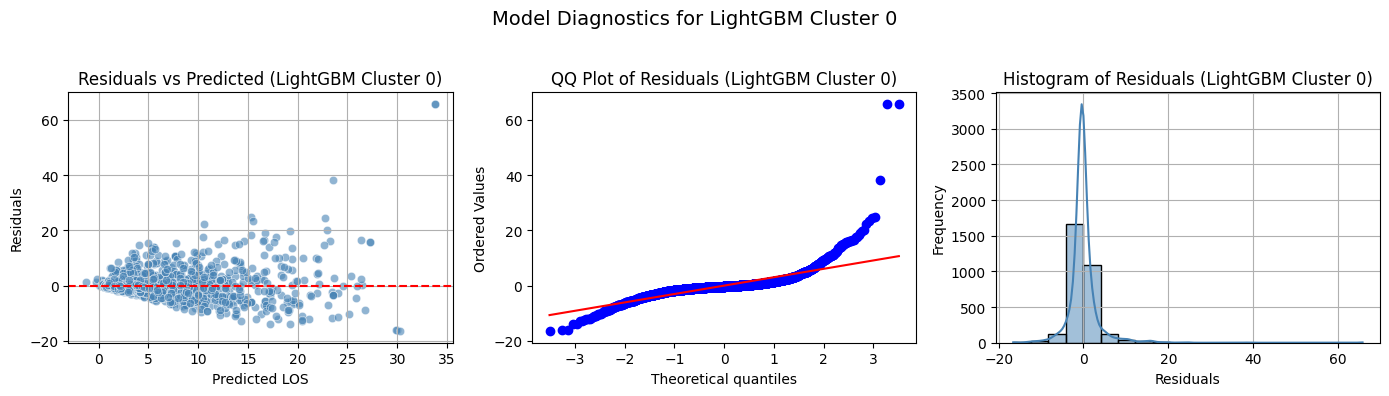

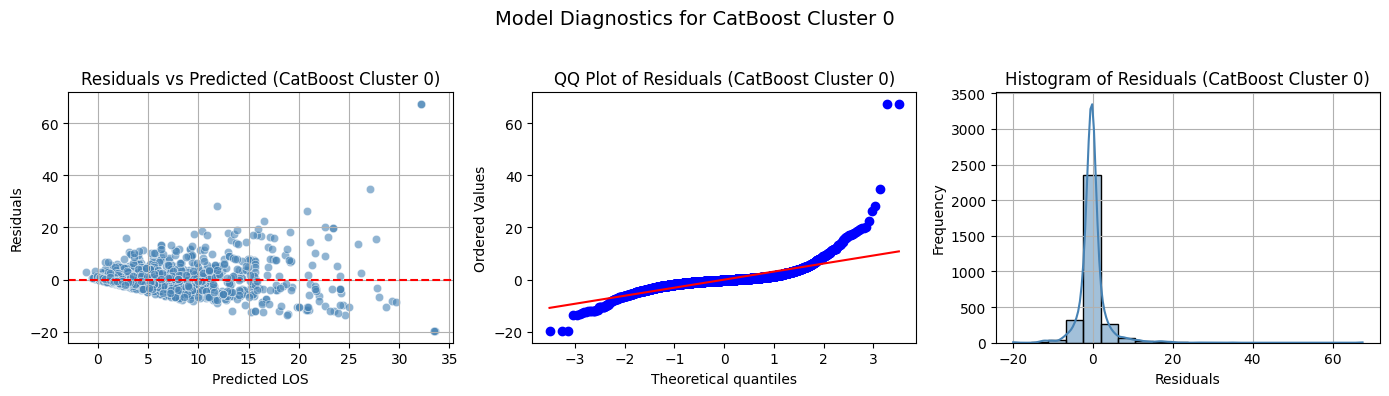

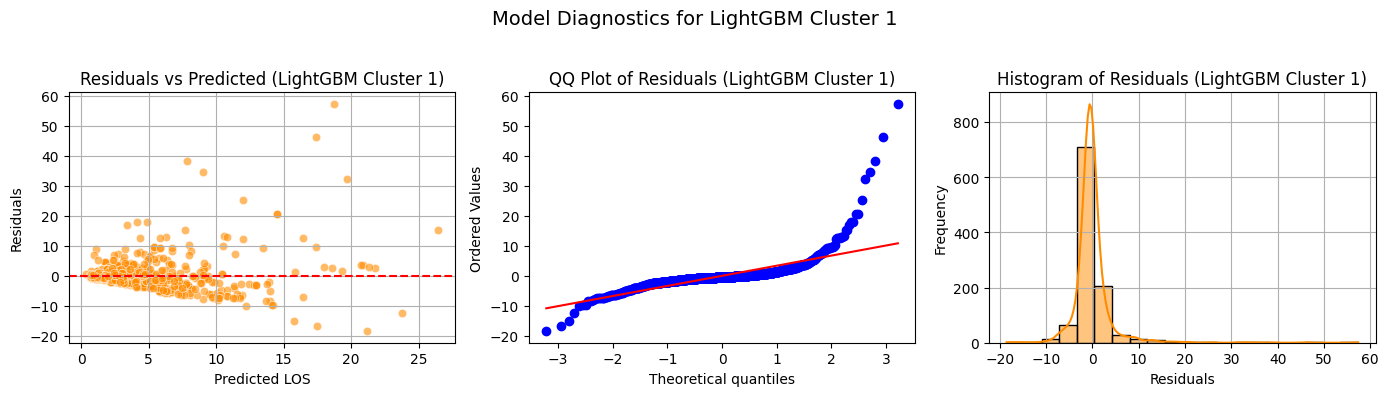

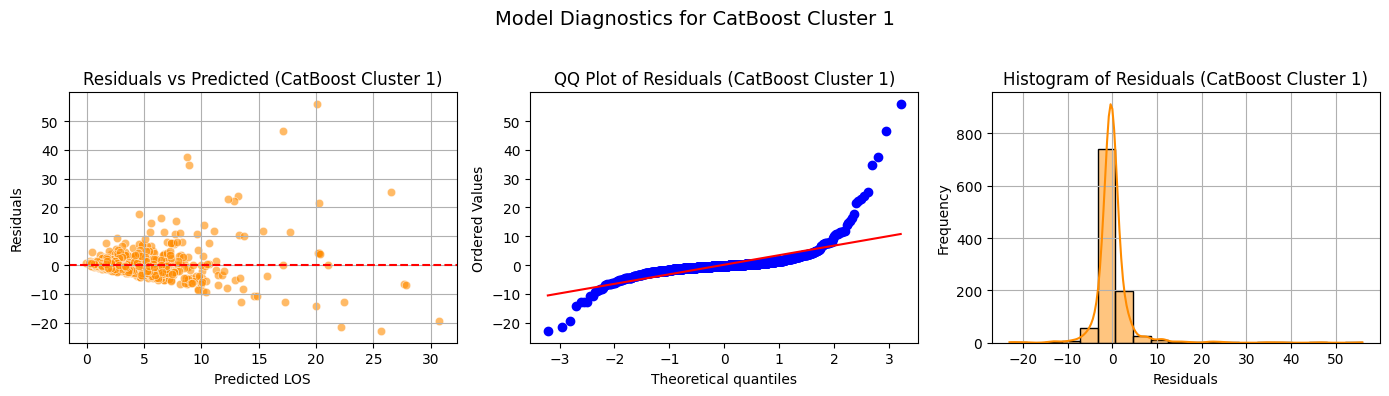

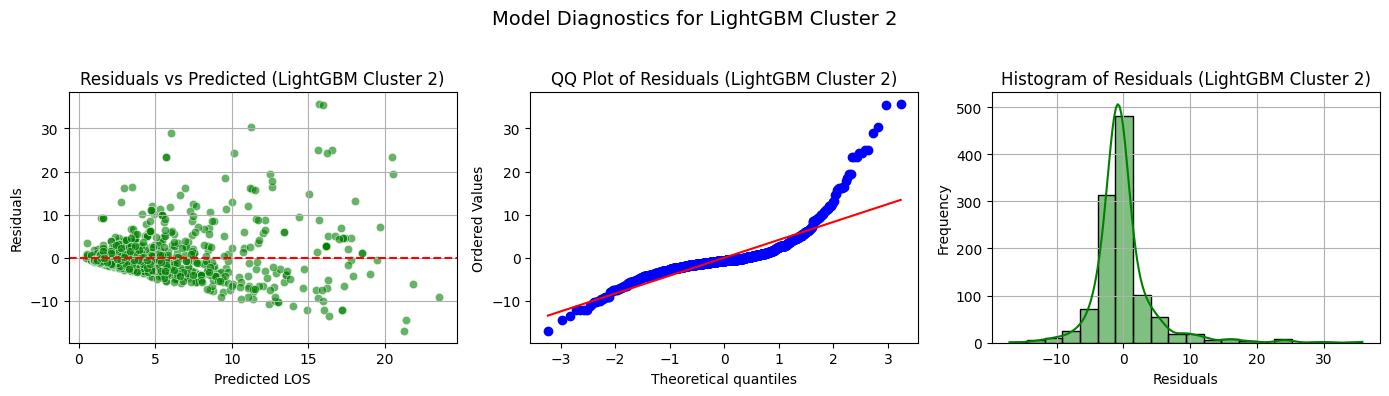

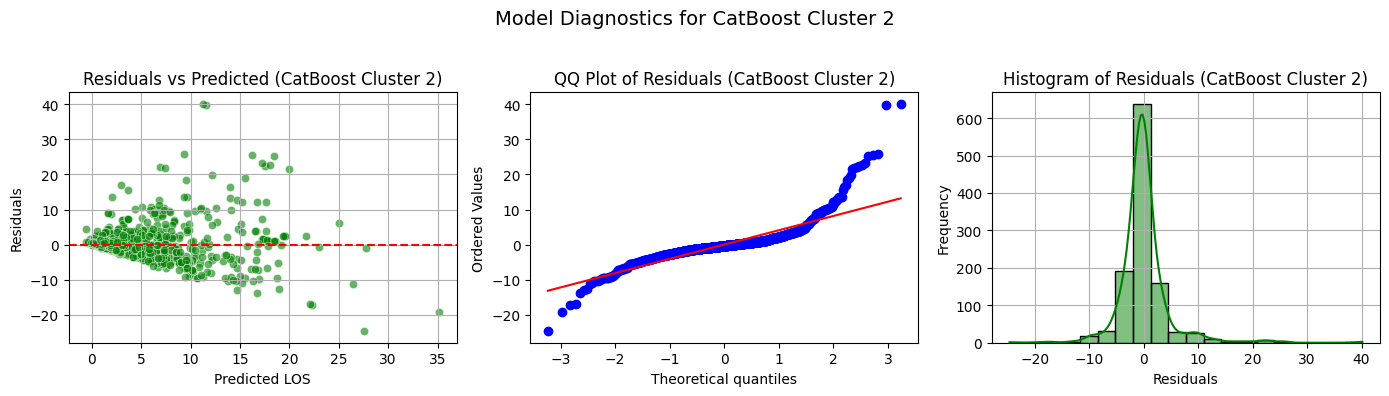

In [21]:
# Colors for clusters
cluster_colors = ['steelblue', 'darkorange', 'green']

# Function to create diagnostic plots
def create_plots(y_true, y_pred, residuals, model_name, cluster_num, color):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Residuals vs Predicted
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axes[0], color=color)
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title(f"Residuals vs Predicted ({model_name} Cluster {cluster_num})")
    axes[0].set_xlabel("Predicted LOS")
    axes[0].set_ylabel("Residuals")
    axes[0].grid(True)

    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title(f"QQ Plot of Residuals ({model_name} Cluster {cluster_num})")

    # Histogram of Residuals
    sns.histplot(residuals, bins=20, kde=True, ax=axes[2], color=color)
    axes[2].set_title(f"Histogram of Residuals ({model_name} Cluster {cluster_num})")
    axes[2].set_xlabel("Residuals")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(True)

    plt.suptitle(f"Model Diagnostics for {model_name} Cluster {cluster_num}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- For LightGBM and CatBoost Models --- 
# LightGBM (Cluster 0)
y_true_all_lgb_0 = np.array(y_true_all_lgb_0)
y_pred_all_lgb_0 = np.array(y_pred_all_lgb_0)
residuals_lgb_0 = y_true_all_lgb_0 - y_pred_all_lgb_0
create_plots(y_true_all_lgb_0, y_pred_all_lgb_0, residuals_lgb_0, "LightGBM", 0, cluster_colors[0])

# CatBoost (Cluster 0)
y_true_all_cb_0 = np.array(y_true_all_cb_0)
y_pred_all_cb_0 = np.array(y_pred_all_cb_0)
residuals_cb_0 = y_true_all_cb_0 - y_pred_all_cb_0
create_plots(y_true_all_cb_0, y_pred_all_cb_0, residuals_cb_0, "CatBoost", 0, cluster_colors[0])

# LightGBM (Cluster 1)
y_true_all_lgb_1 = np.array(y_true_all_lgb_1)
y_pred_all_lgb_1 = np.array(y_pred_all_lgb_1)
residuals_lgb_1 = y_true_all_lgb_1 - y_pred_all_lgb_1
create_plots(y_true_all_lgb_1, y_pred_all_lgb_1, residuals_lgb_1, "LightGBM", 1, cluster_colors[1])

# CatBoost (Cluster 1)
y_true_all_cb_1 = np.array(y_true_all_cb_1)
y_pred_all_cb_1 = np.array(y_pred_all_cb_1)
residuals_cb_1 = y_true_all_cb_1 - y_pred_all_cb_1
create_plots(y_true_all_cb_1, y_pred_all_cb_1, residuals_cb_1, "CatBoost", 1, cluster_colors[1])

# LightGBM (Cluster 2)
y_true_all_lgb_2 = np.array(y_true_all_lgb_2)
y_pred_all_lgb_2 = np.array(y_pred_all_lgb_2)
residuals_lgb_2 = y_true_all_lgb_2 - y_pred_all_lgb_2
create_plots(y_true_all_lgb_2, y_pred_all_lgb_2, residuals_lgb_2, "LightGBM", 2, cluster_colors[2])

# CatBoost (Cluster 2)
y_true_all_cb_2 = np.array(y_true_all_cb_2)
y_pred_all_cb_2 = np.array(y_pred_all_cb_2)
residuals_cb_2 = y_true_all_cb_2 - y_pred_all_cb_2
create_plots(y_true_all_cb_2, y_pred_all_cb_2, residuals_cb_2, "CatBoost", 2, cluster_colors[2])


From out residual & qq plots, we observe the following:

- Overall, the tails of the qq plots for clusters 1 and 2 appear to be more connected than for cluster 0, indicating far more outliers in those clusters
- the performance between lightgbm and catboost for cluster 0 look very similar, while catboost appears to be performing better for the other clusters
- the residual plots for clusters 1 and 2 appear to be more spread out, indicating heteroscadicity, with a slight improvement to this when using catboost, but still overall having subpar predictions.

Based off of these observations, our main focus should be on improving the models for clusters 1 and 2, however even though cluster 0 is acceptable in its current state with an r-squared of 0.62, we will still improve cluster 0 as well since it did struggle with fatter tails for it's qq plot.

## Fixing Our Niche Models:

In order to fix our models, we will incorporate the same improvements we did to our general model, as they did have a quantifiable impact.

### Cluster 0 Fixed for LightGBM

In [24]:
# --- Define MAPE ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Load Data ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Feature Engineering ---
df['age_dxcount'] = df['anchor_age'] * df['dx_count']
df['spo2_rr'] = df['min_SpO2'] * df['max_rr']
df['hr_variability'] = df['max_hr'] - df['min_hr']
df['renal_severity'] = df['max_creatinine'] - df['min_creatinine']
df['elderly_flag'] = (df['anchor_age'] >= 70).astype(int)
df['multi_morbidity'] = (df['dx_count'] >= 3).astype(int)

# --- Log Transformation for Target ---
df['los_log'] = np.log1p(df['los'])

# --- Label Encode Categoricals ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# --- Filter for Cluster 0 ---
df_cluster_0 = df[df['cluster'] == 0].copy()
target_0 = 'los_log'
groups_0 = df_cluster_0['subject_id']
X_0 = df_cluster_0.drop(columns=['subject_id', 'los', target_0])
y_0 = df_cluster_0[target_0]

# --- Initialize Metrics and CV ---
rmse_scores_0, mae_scores_0, r2_scores_0, mape_scores_0, medae_scores_0 = [], [], [], [], []
gkf_0 = GroupKFold(n_splits=5)

y_true_all_lgb_0, y_pred_all_lgb_0 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_0, val_idx_0) in enumerate(gkf_0.split(X_0, y_0, groups_0)):
    print(f"\nFold {fold + 1}/5")

    X_train_0, X_val_0 = X_0.iloc[train_idx_0], X_0.iloc[val_idx_0]
    y_train_0, y_val_0 = y_0.iloc[train_idx_0], y_0.iloc[val_idx_0]

    # Define the LightGBM model with Huber loss
    model_0 = LGBMRegressor(
        objective='huber',
        alpha=0.9,
        learning_rate=0.05,
        n_estimators=1000
    )

    model_0.fit(
        X_train_0, y_train_0,
        eval_set=[(X_val_0, y_val_0)],
        eval_metric='rmse',
        categorical_feature=categorical_cols,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=50)
        ]
    )

    # Predict the target variable
    y_pred_0 = model_0.predict(X_val_0)
    y_true_all_lgb_0.extend(y_val_0)
    y_pred_all_lgb_0.extend(y_pred_0)

    # --- Evaluation ---
    rmse_0 = np.sqrt(mean_squared_error(y_val_0, y_pred_0))
    mae_0 = mean_absolute_error(y_val_0, y_pred_0)
    medae_0 = median_absolute_error(y_val_0, y_pred_0)
    r2_0 = r2_score(y_val_0, y_pred_0)
    mape_0 = mean_absolute_percentage_error(y_val_0, y_pred_0)

    print(f"  RMSE : {rmse_0:.4f}")
    print(f"  MAE  : {mae_0:.4f}")
    print(f"  MedAE: {medae_0:.4f}")
    print(f"  R²   : {r2_0:.4f}")
    print(f"  MAPE : {mape_0:.2f}%")

    # Store metrics
    rmse_scores_0.append(rmse_0)
    mae_scores_0.append(mae_0)
    medae_scores_0.append(medae_0)
    r2_scores_0.append(r2_0)
    mape_scores_0.append(mape_0)

# --- Final Summary ---
print("\n====== Cluster 0 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_0):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_0):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_0):.4f}")
print(f"Average R²   : {np.mean(r2_scores_0):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_0):.2f}%")



Fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3009
[LightGBM] [Info] Number of data points in the train set: 2482, number of used features: 33
[LightGBM] [Info] Start training from score 1.301415
Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 0.417449	valid_0's huber: 0.085068
[100]	valid_0's rmse: 0.402813	valid_0's huber: 0.0803271
Early stopping, best iteration is:
[116]	valid_0's rmse: 0.402333	valid_0's huber: 0.0802038
  RMSE : 0.4023
  MAE  : 0.3051
  MedAE: 0.2260
  R²   : 0.6792
  MAPE : 31.75%

Fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3012
[LightGBM] [Info] Number of data points in the train set: 2482, number of used features: 33
[Li

### Cluster 0 Fixed for CatBoost

In [27]:
# --- Define MAPE ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Load Data ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Feature Engineering ---
df['age_dxcount'] = df['anchor_age'] * df['dx_count']
df['spo2_rr'] = df['min_SpO2'] * df['max_rr']
df['hr_variability'] = df['max_hr'] - df['min_hr']
df['renal_severity'] = df['max_creatinine'] - df['min_creatinine']
df['elderly_flag'] = (df['anchor_age'] >= 70).astype(int)
df['multi_morbidity'] = (df['dx_count'] >= 3).astype(int)

# --- Log Transformation for Target ---
df['los_log'] = np.log1p(df['los'])

# --- Label Encode Categoricals ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# --- Filter for Cluster 0 ---
df_cluster_0 = df[df['cluster'] == 0].copy()
target_0 = 'los_log'
groups_0 = df_cluster_0['subject_id']
X_0 = df_cluster_0.drop(columns=['subject_id', 'los', target_0])
y_0 = df_cluster_0[target_0]

# --- Initialize Metrics and CV ---
rmse_scores_0, mae_scores_0, r2_scores_0, mape_scores_0, medae_scores_0 = [], [], [], [], []
gkf_0 = GroupKFold(n_splits=5)

y_true_all_cb_0, y_pred_all_cb_0 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_0, val_idx_0) in enumerate(gkf_0.split(X_0, y_0, groups_0)):
    print(f"\nFold {fold + 1}/5")

    X_train_0, X_val_0 = X_0.iloc[train_idx_0], X_0.iloc[val_idx_0]
    y_train_0, y_val_0 = y_0.iloc[train_idx_0], y_0.iloc[val_idx_0]

    # Define the CatBoost model
    model_0 = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        cat_features=categorical_cols,
        random_seed=42,
        logging_level='Silent'
    )

    model_0.fit(X_train_0, y_train_0)

    # Predict
    y_pred_0 = model_0.predict(X_val_0)
    y_true_all_cb_0.extend(y_val_0)
    y_pred_all_cb_0.extend(y_pred_0)

    # --- Evaluation ---
    rmse_0 = np.sqrt(mean_squared_error(y_val_0, y_pred_0))
    mae_0 = mean_absolute_error(y_val_0, y_pred_0)
    medae_0 = median_absolute_error(y_val_0, y_pred_0)
    r2_0 = r2_score(y_val_0, y_pred_0)
    mape_0 = mean_absolute_percentage_error(y_val_0, y_pred_0)

    print(f"  RMSE : {rmse_0:.4f}")
    print(f"  MAE  : {mae_0:.4f}")
    print(f"  MedAE: {medae_0:.4f}")
    print(f"  R²   : {r2_0:.4f}")
    print(f"  MAPE : {mape_0:.2f}%")

    # Store metrics
    rmse_scores_0.append(rmse_0)
    mae_scores_0.append(mae_0)
    medae_scores_0.append(medae_0)
    r2_scores_0.append(r2_0)
    mape_scores_0.append(mape_0)

# --- Final Summary ---
print("\n====== Cluster 0 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_0):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_0):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_0):.4f}")
print(f"Average R²   : {np.mean(r2_scores_0):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_0):.2f}%")



Fold 1/5
  RMSE : 0.3993
  MAE  : 0.3044
  MedAE: 0.2385
  R²   : 0.6841
  MAPE : 31.77%

Fold 2/5
  RMSE : 0.3809
  MAE  : 0.2911
  MedAE: 0.2303
  R²   : 0.7304
  MAPE : 28.02%

Fold 3/5
  RMSE : 0.3722
  MAE  : 0.2926
  MedAE: 0.2364
  R²   : 0.7467
  MAPE : 35.35%

Fold 4/5
  RMSE : 0.4144
  MAE  : 0.3216
  MedAE: 0.2615
  R²   : 0.6848
  MAPE : 37.52%

Fold 5/5
  RMSE : 0.3971
  MAE  : 0.2971
  MedAE: 0.2210
  R²   : 0.6793
  MAPE : 36.84%

====== Cluster 0 Cross-Validation Summary ======
Average RMSE : 0.3928
Average MAE  : 0.3014
Average MedAE: 0.2376
Average R²   : 0.7051
Average MAPE : 33.90%


### Cluster 1 Fixed for LightGBM

In [25]:
# --- Define MAPE ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Load Data ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Feature Engineering ---
df['age_dxcount'] = df['anchor_age'] * df['dx_count']
df['spo2_rr'] = df['min_SpO2'] * df['max_rr']
df['hr_variability'] = df['max_hr'] - df['min_hr']
df['renal_severity'] = df['max_creatinine'] - df['min_creatinine']
df['elderly_flag'] = (df['anchor_age'] >= 70).astype(int)
df['multi_morbidity'] = (df['dx_count'] >= 3).astype(int)

# --- Log Transformation for Target ---
df['los_log'] = np.log1p(df['los'])

# --- Label Encode Categoricals ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# --- Filter for Cluster 1 ---
df_cluster_1 = df[df['cluster'] == 1].copy()
target_1 = 'los_log'  # Using the log-transformed target
groups_1 = df_cluster_1['subject_id']
X_1 = df_cluster_1.drop(columns=['subject_id', 'los', target_1])
y_1 = df_cluster_1[target_1]

# --- Initialize Metrics and CV ---
rmse_scores_1, mae_scores_1, r2_scores_1, mape_scores_1, medae_scores_1 = [], [], [], [], []
gkf_1 = GroupKFold(n_splits=5)

y_true_all_lgb_1, y_pred_all_lgb_1 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_1, val_idx_1) in enumerate(gkf_1.split(X_1, y_1, groups_1)):
    print(f"\nFold {fold + 1}/5")

    X_train_1, X_val_1 = X_1.iloc[train_idx_1], X_1.iloc[val_idx_1]
    y_train_1, y_val_1 = y_1.iloc[train_idx_1], y_1.iloc[val_idx_1]

    # Define the LightGBM model with Huber loss
    model_1 = LGBMRegressor(
        objective='huber',
        alpha=0.9,  # Huber loss delta threshold
        learning_rate=0.05,
        n_estimators=1000
    )

    model_1.fit(
        X_train_1, y_train_1,
        eval_set=[(X_val_1, y_val_1)],
        eval_metric='rmse',
        categorical_feature=categorical_cols,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=50)
        ]
    )

    # Predict the target variable
    y_pred_1 = model_1.predict(X_val_1)
    y_true_all_lgb_1.extend(y_val_1)
    y_pred_all_lgb_1.extend(y_pred_1)

    # --- Evaluation ---
    rmse_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_1))
    mae_1 = mean_absolute_error(y_val_1, y_pred_1)
    medae_1 = median_absolute_error(y_val_1, y_pred_1)
    r2_1 = r2_score(y_val_1, y_pred_1)
    mape_1 = mean_absolute_percentage_error(y_val_1, y_pred_1)

    print(f"  RMSE : {rmse_1:.4f}")
    print(f"  MAE  : {mae_1:.4f}")
    print(f"  MedAE: {medae_1:.4f}")
    print(f"  R²   : {r2_1:.4f}")
    print(f"  MAPE : {mape_1:.2f}%")

    # Store metrics
    rmse_scores_1.append(rmse_1)
    mae_scores_1.append(mae_1)
    medae_scores_1.append(medae_1)
    r2_scores_1.append(r2_1)
    mape_scores_1.append(mape_1)

# --- Final Summary ---
print("\n====== Cluster 1 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_1):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_1):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_1):.4f}")
print(f"Average R²   : {np.mean(r2_scores_1):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_1):.2f}%")



Fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2461
[LightGBM] [Info] Number of data points in the train set: 847, number of used features: 33
[LightGBM] [Info] Start training from score 1.247350
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's rmse: 0.444399	valid_0's huber: 0.094181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid_0's rmse: 0.436131	valid_0's huber: 0.0923925
Early stopping, best iteration is:
[83]	valid_0's rmse: 0.435298	valid_0's huber: 0.0916923
  RMSE : 0.4353
  MAE  : 0.3262
  MedAE: 0.2486
  R²   : 0.5173
  MAPE : 37.18%

Fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to re

### Cluster 1 Fixed for Catboost:

In [28]:
# --- Define MAPE ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Load Data ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Feature Engineering ---
df['age_dxcount'] = df['anchor_age'] * df['dx_count']
df['spo2_rr'] = df['min_SpO2'] * df['max_rr']
df['hr_variability'] = df['max_hr'] - df['min_hr']
df['renal_severity'] = df['max_creatinine'] - df['min_creatinine']
df['elderly_flag'] = (df['anchor_age'] >= 70).astype(int)
df['multi_morbidity'] = (df['dx_count'] >= 3).astype(int)

# --- Log Transformation for Target ---
df['los_log'] = np.log1p(df['los'])

# --- Label Encode Categoricals ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# --- Filter for Cluster 1 ---
df_cluster_1 = df[df['cluster'] == 1].copy()
target_1 = 'los_log'  # Using the log-transformed target
groups_1 = df_cluster_1['subject_id']
X_1 = df_cluster_1.drop(columns=['subject_id', 'los', target_1])
y_1 = df_cluster_1[target_1]

# --- Initialize Metrics and CV ---
rmse_scores_1, mae_scores_1, r2_scores_1, mape_scores_1, medae_scores_1 = [], [], [], [], []
gkf_1 = GroupKFold(n_splits=5)

y_true_all_cb_1, y_pred_all_cb_1 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_1, val_idx_1) in enumerate(gkf_1.split(X_1, y_1, groups_1)):
    print(f"\nFold {fold + 1}/5")

    X_train_1, X_val_1 = X_1.iloc[train_idx_1], X_1.iloc[val_idx_1]
    y_train_1, y_val_1 = y_1.iloc[train_idx_1], y_1.iloc[val_idx_1]

    # Define the CatBoost model with default settings
    model_1 = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        cat_features=categorical_cols,  # Specify categorical columns
        random_seed=42,
        logging_level='Silent'  # To suppress verbose output
    )

    model_1.fit(X_train_1, y_train_1)

    # Predict the target variable
    y_pred_1 = model_1.predict(X_val_1)
    y_true_all_cb_1.extend(y_val_1)
    y_pred_all_cb_1.extend(y_pred_1)

    # --- Evaluation ---
    rmse_1 = np.sqrt(mean_squared_error(y_val_1, y_pred_1))
    mae_1 = mean_absolute_error(y_val_1, y_pred_1)
    medae_1 = median_absolute_error(y_val_1, y_pred_1)
    r2_1 = r2_score(y_val_1, y_pred_1)
    mape_1 = mean_absolute_percentage_error(y_val_1, y_pred_1)

    print(f"  RMSE : {rmse_1:.4f}")
    print(f"  MAE  : {mae_1:.4f}")
    print(f"  MedAE: {medae_1:.4f}")
    print(f"  R²   : {r2_1:.4f}")
    print(f"  MAPE : {mape_1:.2f}%")

    # Store metrics
    rmse_scores_1.append(rmse_1)
    mae_scores_1.append(mae_1)
    medae_scores_1.append(medae_1)
    r2_scores_1.append(r2_1)
    mape_scores_1.append(mape_1)

# --- Final Summary ---
print("\n====== Cluster 1 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_1):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_1):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_1):.4f}")
print(f"Average R²   : {np.mean(r2_scores_1):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_1):.2f}%")



Fold 1/5
  RMSE : 0.4027
  MAE  : 0.2994
  MedAE: 0.2296
  R²   : 0.5869
  MAPE : 33.10%

Fold 2/5
  RMSE : 0.3998
  MAE  : 0.2977
  MedAE: 0.2245
  R²   : 0.5829
  MAPE : 32.77%

Fold 3/5
  RMSE : 0.3974
  MAE  : 0.3029
  MedAE: 0.2139
  R²   : 0.6832
  MAPE : 39.59%

Fold 4/5
  RMSE : 0.4781
  MAE  : 0.3378
  MedAE: 0.2509
  R²   : 0.4594
  MAPE : 30.94%

Fold 5/5
  RMSE : 0.4316
  MAE  : 0.3235
  MedAE: 0.2425
  R²   : 0.6128
  MAPE : 31.12%

====== Cluster 1 Cross-Validation Summary ======
Average RMSE : 0.4219
Average MAE  : 0.3123
Average MedAE: 0.2323
Average R²   : 0.5850
Average MAPE : 33.50%


## Cluster 2 Fixed for LightGBM:

In [29]:
# --- Define MAPE ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Load Data ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Feature Engineering ---
df['age_dxcount'] = df['anchor_age'] * df['dx_count']
df['spo2_rr'] = df['min_SpO2'] * df['max_rr']
df['hr_variability'] = df['max_hr'] - df['min_hr']
df['renal_severity'] = df['max_creatinine'] - df['min_creatinine']
df['elderly_flag'] = (df['anchor_age'] >= 70).astype(int)
df['multi_morbidity'] = (df['dx_count'] >= 3).astype(int)

# --- Log Transformation for Target ---
df['los_log'] = np.log1p(df['los'])

# --- Label Encode Categoricals ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# --- Filter for Cluster 2 ---
df_cluster_2 = df[df['cluster'] == 2].copy()
target_2 = 'los_log'  # Using the log-transformed target
groups_2 = df_cluster_2['subject_id']
X_2 = df_cluster_2.drop(columns=['subject_id', 'los', target_2])
y_2 = df_cluster_2[target_2]

# --- Initialize Metrics and CV ---
rmse_scores_2, mae_scores_2, r2_scores_2, mape_scores_2, medae_scores_2 = [], [], [], [], []
gkf_2 = GroupKFold(n_splits=5)

y_true_all_lgb_2, y_pred_all_lgb_2 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_2, val_idx_2) in enumerate(gkf_2.split(X_2, y_2, groups_2)):
    print(f"\nFold {fold + 1}/5")

    X_train_2, X_val_2 = X_2.iloc[train_idx_2], X_2.iloc[val_idx_2]
    y_train_2, y_val_2 = y_2.iloc[train_idx_2], y_2.iloc[val_idx_2]

    # Define the LightGBM model with Huber loss
    model_2 = LGBMRegressor(
        objective='huber',
        alpha=0.9,  # Huber loss delta threshold
        learning_rate=0.05,
        n_estimators=1000
    )

    model_2.fit(
        X_train_2, y_train_2,
        eval_set=[(X_val_2, y_val_2)],
        eval_metric='rmse',
        categorical_feature=categorical_cols,
        callbacks=[
            early_stopping(stopping_rounds=20),
            log_evaluation(period=50)
        ]
    )

    # Predict the target variable
    y_pred_2 = model_2.predict(X_val_2)
    y_true_all_lgb_2.extend(y_val_2)
    y_pred_all_lgb_2.extend(y_pred_2)

    # --- Evaluation ---
    rmse_2 = np.sqrt(mean_squared_error(y_val_2, y_pred_2))
    mae_2 = mean_absolute_error(y_val_2, y_pred_2)
    medae_2 = median_absolute_error(y_val_2, y_pred_2)
    r2_2 = r2_score(y_val_2, y_pred_2)
    mape_2 = mean_absolute_percentage_error(y_val_2, y_pred_2)

    print(f"  RMSE : {rmse_2:.4f}")
    print(f"  MAE  : {mae_2:.4f}")
    print(f"  MedAE: {medae_2:.4f}")
    print(f"  R²   : {r2_2:.4f}")
    print(f"  MAPE : {mape_2:.2f}%")

    # Store metrics
    rmse_scores_2.append(rmse_2)
    mae_scores_2.append(mae_2)
    medae_scores_2.append(medae_2)
    r2_scores_2.append(r2_2)
    mape_scores_2.append(mape_2)

# --- Final Summary ---
print("\n====== Cluster 2 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_2):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_2):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_2):.4f}")
print(f"Average R²   : {np.mean(r2_scores_2):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_2):.2f}%")



Fold 1/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 33
[LightGBM] [Info] Start training from score 1.419784
Training until validation scores don't improve for 20 rounds
[50]	valid_0's rmse: 0.463536	valid_0's huber: 0.105927
[100]	valid_0's rmse: 0.45927	valid_0's huber: 0.103165
Early stopping, best iteration is:
[83]	valid_0's rmse: 0.457445	valid_0's huber: 0.102312
  RMSE : 0.4574
  MAE  : 0.3697
  MedAE: 0.2942
  R²   : 0.6211
  MAPE : 34.00%

Fold 2/5
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2532
[LightGBM] [Info] Number of data points in the train set: 902, number of used features: 33
[LightGBM

### Fixed Cluster 2 for CatBoost:

In [30]:
# --- Define MAPE ---
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# --- Load Data ---
df.drop(columns=['admission_type', 'admission_location'], inplace=True, errors='ignore')
df['marital_status'].fillna('Unknown')

# --- Feature Engineering ---
df['age_dxcount'] = df['anchor_age'] * df['dx_count']
df['spo2_rr'] = df['min_SpO2'] * df['max_rr']
df['hr_variability'] = df['max_hr'] - df['min_hr']
df['renal_severity'] = df['max_creatinine'] - df['min_creatinine']
df['elderly_flag'] = (df['anchor_age'] >= 70).astype(int)
df['multi_morbidity'] = (df['dx_count'] >= 3).astype(int)

# --- Log Transformation for Target ---
df['los_log'] = np.log1p(df['los'])

# --- Label Encode Categoricals ---
expected_categorical_cols = [
    'gender', 'insurance', 'marital_status',
    'long_title_grouped', 'race_grouped',
    'admission_type_grouped', 'admission_location_grouped'
]
categorical_cols = [col for col in expected_categorical_cols if col in df.columns]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# --- Filter for Cluster 2 ---
df_cluster_2 = df[df['cluster'] == 2].copy()
target_2 = 'los_log'  # Using the log-transformed target
groups_2 = df_cluster_2['subject_id']
X_2 = df_cluster_2.drop(columns=['subject_id', 'los', target_2])
y_2 = df_cluster_2[target_2]

# --- Initialize Metrics and CV ---
rmse_scores_2, mae_scores_2, r2_scores_2, mape_scores_2, medae_scores_2 = [], [], [], [], []
gkf_2 = GroupKFold(n_splits=5)

y_true_all_cb_2, y_pred_all_cb_2 = [], []

# --- Cross-validation Loop ---
for fold, (train_idx_2, val_idx_2) in enumerate(gkf_2.split(X_2, y_2, groups_2)):
    print(f"\nFold {fold + 1}/5")

    X_train_2, X_val_2 = X_2.iloc[train_idx_2], X_2.iloc[val_idx_2]
    y_train_2, y_val_2 = y_2.iloc[train_idx_2], y_2.iloc[val_idx_2]

    # Define the CatBoost model with default settings
    model_2 = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='RMSE',
        cat_features=categorical_cols,  # Specify categorical columns
        random_seed=42,
        logging_level='Silent'  # To suppress verbose output
    )

    model_2.fit(X_train_2, y_train_2)

    # Predict the target variable
    y_pred_2 = model_2.predict(X_val_2)
    y_true_all_cb_2.extend(y_val_2)
    y_pred_all_cb_2.extend(y_pred_2)

    # --- Evaluation ---
    rmse_2 = np.sqrt(mean_squared_error(y_val_2, y_pred_2))
    mae_2 = mean_absolute_error(y_val_2, y_pred_2)
    medae_2 = median_absolute_error(y_val_2, y_pred_2)
    r2_2 = r2_score(y_val_2, y_pred_2)
    mape_2 = mean_absolute_percentage_error(y_val_2, y_pred_2)

    print(f"  RMSE : {rmse_2:.4f}")
    print(f"  MAE  : {mae_2:.4f}")
    print(f"  MedAE: {medae_2:.4f}")
    print(f"  R²   : {r2_2:.4f}")
    print(f"  MAPE : {mape_2:.2f}%")

    # Store metrics
    rmse_scores_2.append(rmse_2)
    mae_scores_2.append(mae_2)
    medae_scores_2.append(medae_2)
    r2_scores_2.append(r2_2)
    mape_scores_2.append(mape_2)

# --- Final Summary ---
print("\n====== Cluster 2 Cross-Validation Summary ======")
print(f"Average RMSE : {np.mean(rmse_scores_2):.4f}")
print(f"Average MAE  : {np.mean(mae_scores_2):.4f}")
print(f"Average MedAE: {np.mean(medae_scores_2):.4f}")
print(f"Average R²   : {np.mean(r2_scores_2):.4f}")
print(f"Average MAPE : {np.mean(mape_scores_2):.2f}%")



Fold 1/5
  RMSE : 0.4404
  MAE  : 0.3494
  MedAE: 0.2918
  R²   : 0.6488
  MAPE : 32.35%

Fold 2/5
  RMSE : 0.4637
  MAE  : 0.3558
  MedAE: 0.2898
  R²   : 0.6025
  MAPE : 30.54%

Fold 3/5
  RMSE : 0.5178
  MAE  : 0.3948
  MedAE: 0.3135
  R²   : 0.5615
  MAPE : 38.98%

Fold 4/5
  RMSE : 0.4823
  MAE  : 0.3717
  MedAE: 0.3057
  R²   : 0.6668
  MAPE : 45.57%

Fold 5/5
  RMSE : 0.4298
  MAE  : 0.3409
  MedAE: 0.2736
  R²   : 0.6295
  MAPE : 34.05%

====== Cluster 2 Cross-Validation Summary ======
Average RMSE : 0.4668
Average MAE  : 0.3625
Average MedAE: 0.2949
Average R²   : 0.6218
Average MAPE : 36.30%


### Analysis of Fixed - Average Metrics for Clusters 0, 1 and 2:

#### For Cluster 0:

Massive improvement in both the predictive power for the models:

- RMSE: CatBoost (0.3928) < LightGBM (0.3956). Lower RMSE indicates that CatBoost has a smaller overall error in predicting the length of stay.

- MAE: CatBoost (0.3014) > LightGBM (0.3006) in this metric. This means CatBoost has fewer large errors in predictions compared to LightGBM.

- MedAE: CatBoost (0.2376) is again better than LightGBM (0.2305). CatBoost's median absolute error is smaller, indicating that its predictions are closer to the median of the true values.

- R-squared: CatBoost (0.7051) > LightGBM (0.7013) in explaining the variance in the target variable (length of stay). A higher value means CatBoost better captures the patterns in the data.

- MAPE: CatBoost (33.90%) is better than LightGBM (33.66%), indicating that CatBoost has better accuracy in terms of percentage error relative to the true values.

#### For Cluster 1:

There is a significant improvement in the predictive power for both models for Cluster 1, but to be more specific:


- RMSE: CatBoost (0.4219) performs slightly better than LightGBM (0.4450). Lower RMSE indicates that CatBoost has a smaller overall error in predicting the length of stay.

- MAE: CatBoost (0.3123) also outperforms LightGBM (0.3294) in this metric. This means CatBoost has fewer large errors in predictions compared to LightGBM.

- MedAE: CatBoost (0.2323) is again better than LightGBM (0.2493). CatBoost's median absolute error is smaller, indicating that its predictions are closer to the median of the true values.

- R-squared: CatBoost (0.5850) outperforms LightGBM (0.5394) in explaining the variance in the target variable (length of stay). A higher R² means CatBoost better captures the patterns in the data.

- MAPE: CatBoost (33.50%) is again better than LightGBM (35.92%), indicating that CatBoost has better accuracy in terms of percentage error relative to the true values.

#### For Cluster 2:

Again we see a similar trend for Cluster 2's models, specifically:

- RMSE: CatBoost (0.4668) < LightGBM ( 0.4918), indicating a better overall fit in terms of residual errors.

- MAE: CatBoost (0.3625) < LightGBM (0.3831), showing that CatBoost has smaller average errors in prediction.

- MedAE: CatBoost (0.2949) is again better than LightGBM (0.3039), with CatBoost having a slightly lower median error.

- R-squared: CatBoost (0.6218) has a higher R-squared than LightGBM (0.5812), indicating that CatBoost explains more of the variance in the data.

- MAPE: CatBoost (36.30%) has a lower MAPE than LightGBM (38.50%), meaning CatBoost provides more accurate predictions in terms of percentage error.

## Fixed Residual Analysis:

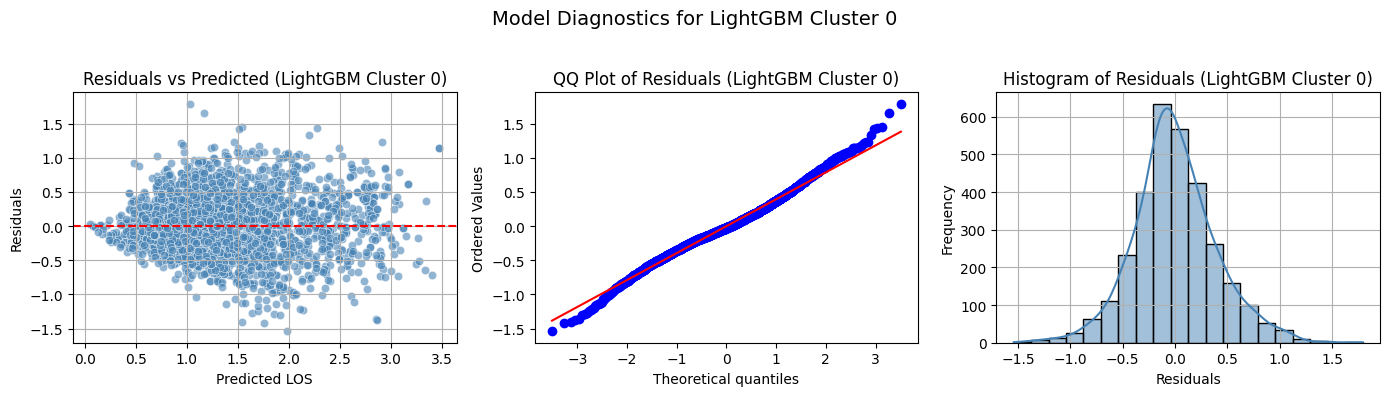

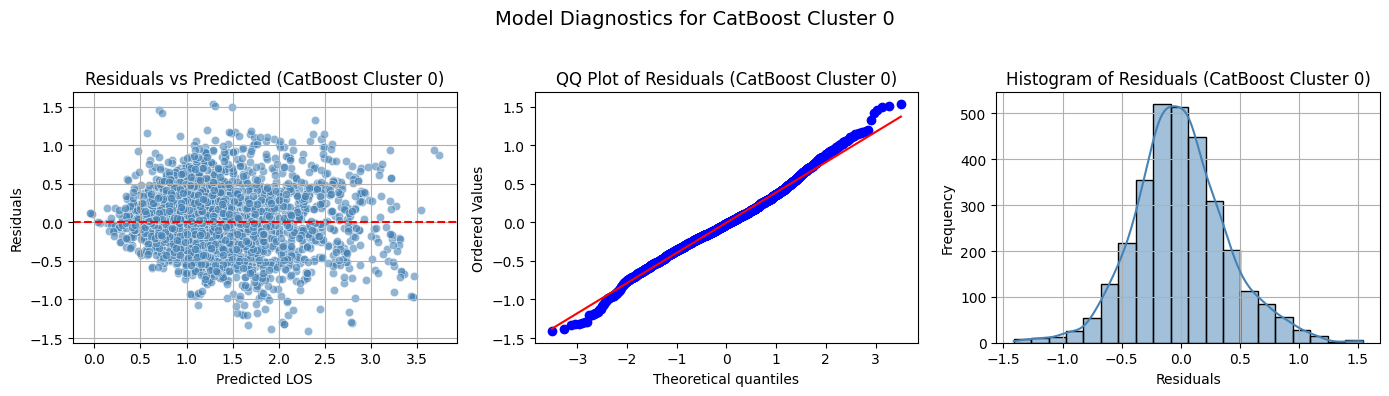

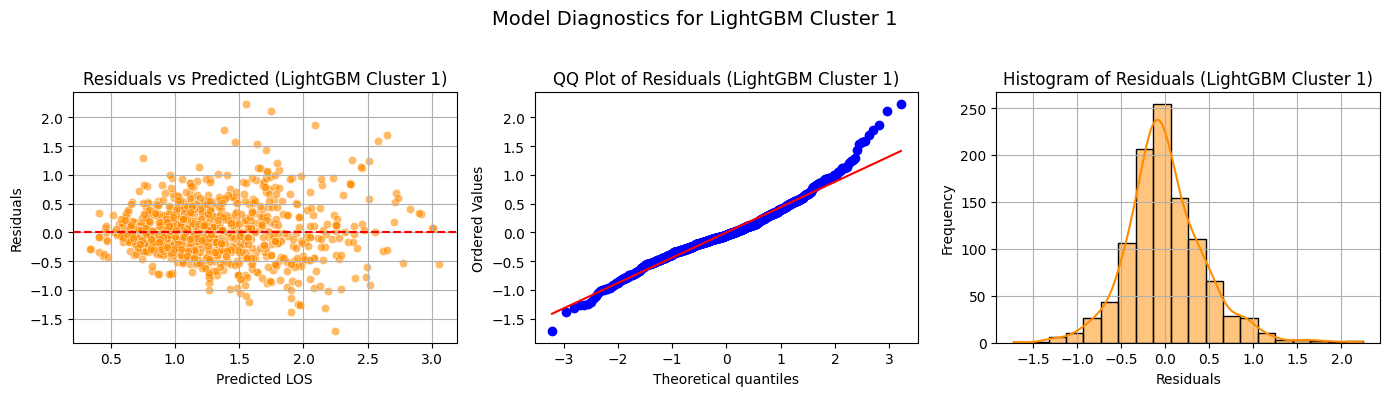

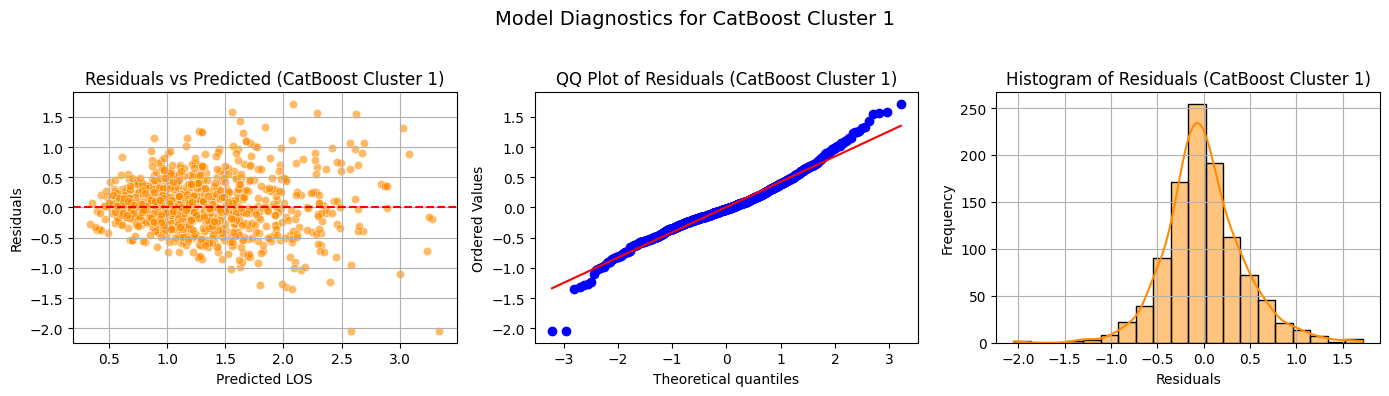

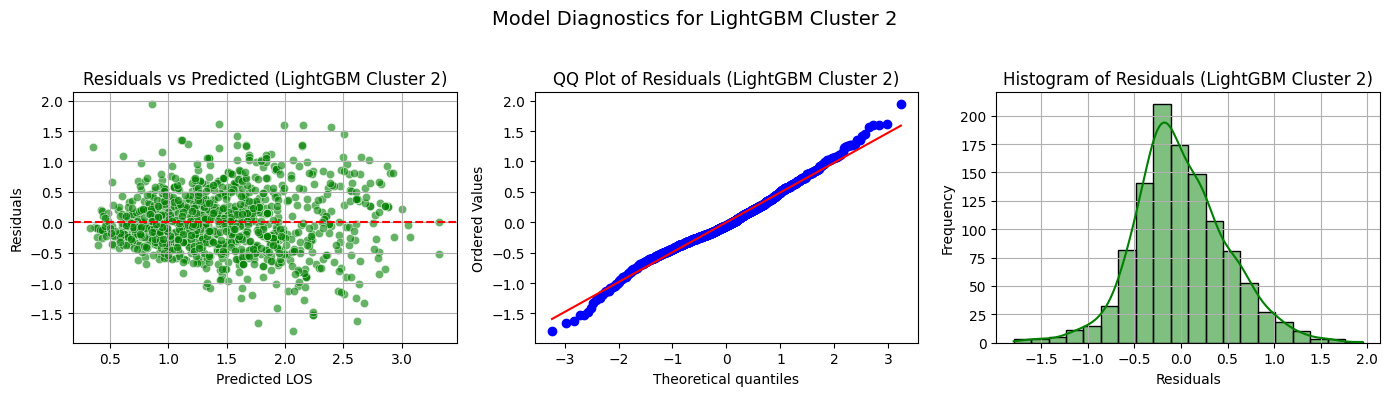

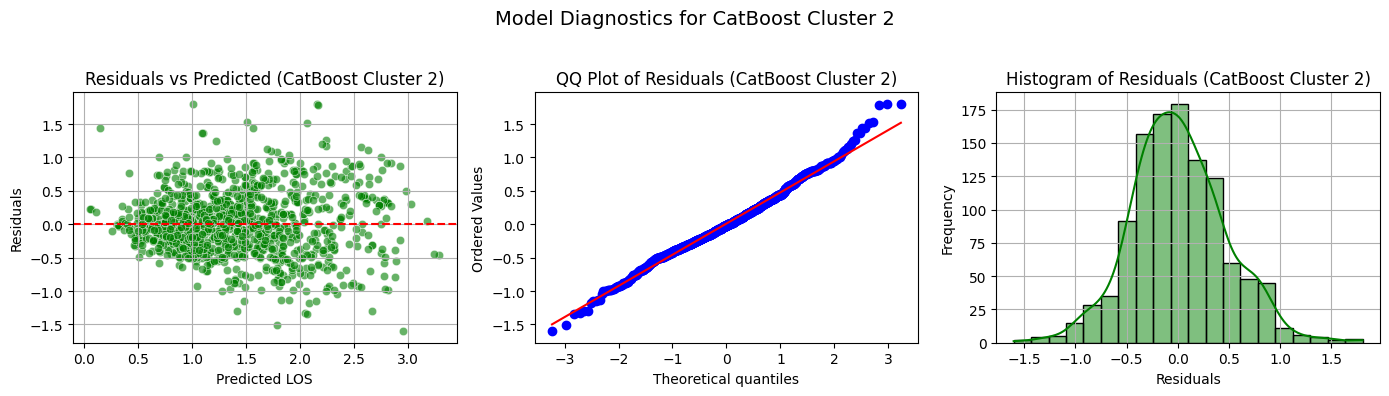

In [31]:
# Colors for clusters
cluster_colors = ['steelblue', 'darkorange', 'green']

# Function to create diagnostic plots
def create_plots(y_true, y_pred, residuals, model_name, cluster_num, color):
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    # Residuals vs Predicted
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, ax=axes[0], color=color)
    axes[0].axhline(0, color='red', linestyle='--')
    axes[0].set_title(f"Residuals vs Predicted ({model_name} Cluster {cluster_num})")
    axes[0].set_xlabel("Predicted LOS")
    axes[0].set_ylabel("Residuals")
    axes[0].grid(True)

    # QQ Plot
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title(f"QQ Plot of Residuals ({model_name} Cluster {cluster_num})")

    # Histogram of Residuals
    sns.histplot(residuals, bins=20, kde=True, ax=axes[2], color=color)
    axes[2].set_title(f"Histogram of Residuals ({model_name} Cluster {cluster_num})")
    axes[2].set_xlabel("Residuals")
    axes[2].set_ylabel("Frequency")
    axes[2].grid(True)

    plt.suptitle(f"Model Diagnostics for {model_name} Cluster {cluster_num}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# --- For LightGBM and CatBoost Models --- 

# --- Model Diagnostics ---

# LightGBM (Cluster 0)
y_true_all_lgb_0 = np.array(y_true_all_lgb_0)
y_pred_all_lgb_0 = np.array(y_pred_all_lgb_0)
residuals_lgb_0 = y_true_all_lgb_0 - y_pred_all_lgb_0
create_plots(y_true_all_lgb_0, y_pred_all_lgb_0, residuals_lgb_0, "LightGBM", 0, cluster_colors[0])

# CatBoost (Cluster 0)
y_true_all_cb_0 = np.array(y_true_all_cb_0)
y_pred_all_cb_0 = np.array(y_pred_all_cb_0)
residuals_cb_0 = y_true_all_cb_0 - y_pred_all_cb_0
create_plots(y_true_all_cb_0, y_pred_all_cb_0, residuals_cb_0, "CatBoost", 0, cluster_colors[0])



# LightGBM (Cluster 1)
y_true_all_lgb_1 = np.array(y_true_all_lgb_1)
y_pred_all_lgb_1 = np.array(y_pred_all_lgb_1)
residuals_lgb_1 = y_true_all_lgb_1 - y_pred_all_lgb_1
create_plots(y_true_all_lgb_1, y_pred_all_lgb_1, residuals_lgb_1, "LightGBM", 1, cluster_colors[1])

# CatBoost (Cluster 1)
y_true_all_cb_1 = np.array(y_true_all_cb_1)
y_pred_all_cb_1 = np.array(y_pred_all_cb_1)
residuals_cb_1 = y_true_all_cb_1 - y_pred_all_cb_1
create_plots(y_true_all_cb_1, y_pred_all_cb_1, residuals_cb_1, "CatBoost", 1, cluster_colors[1])

# LightGBM (Cluster 2)
y_true_all_lgb_2 = np.array(y_true_all_lgb_2)
y_pred_all_lgb_2 = np.array(y_pred_all_lgb_2)
residuals_lgb_2 = y_true_all_lgb_2 - y_pred_all_lgb_2
create_plots(y_true_all_lgb_2, y_pred_all_lgb_2, residuals_lgb_2, "LightGBM", 2, cluster_colors[2])

# CatBoost (Cluster 2)
y_true_all_cb_2 = np.array(y_true_all_cb_2)
y_pred_all_cb_2 = np.array(y_pred_all_cb_2)
residuals_cb_2 = y_true_all_cb_2 - y_pred_all_cb_2
create_plots(y_true_all_cb_2, y_pred_all_cb_2, residuals_cb_2, "CatBoost", 2, cluster_colors[2])


From these plots, we observe massive improvements in both cluster groups, namely:
- Homoscedacity in our residual plots
- More symmetric and normally distributed residuals for our histogram of residuals
- Our qq plots have less prominent tails and are more in line

## Final Conclusions:


Based off of our fixed cluster 1 & 2 models, as well as our initial cluster 0 model:
- All models perform slightly above average in terms of predictive capability, and this was thanks to our log transformation and Huber methods used in Clusters 1 and 2, as well as Cluster 0 having less outlier datapoints.
- CatBoost proved to be the more effective model across all clusters
- Clusters 0 and 2 have very similar R-squared values, meaning they are both equally viable for their prediction goals, namely prediciting refferal and transfer patients.
- Cluster 1 seemed to be the underperformer amongst our clusters, and this could be due to a smaller amount of spinal injury patients that were admitted under emergency within our dataset, which consequently is more of a data problem, rather than an issue with our model. However it still is above the R-suqared threshhold of 0.5, and is still valuable for predictions.
- All our focus group models managed to beat the Mimic IV models used previously, which had an R-squared in the range of 0.05 - 0.28, significantly worse than all of our models.